In [ ]:
import pandas as pd

ampd = pd.read_csv('ampds.csv')
ampd.head(2)

,time,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
0,1333263600000000000,918,43,2,873,0,352.0,0.0,0.0,41.0,...,0.0,58.0,0.0,30.0,0.0,0.0,4.0,0.0,37.0,138.0
1,1333263660000000000,913,43,0,870,0,354.0,0.0,0.0,35.0,...,0.0,58.0,0.0,30.0,0.0,0.0,4.0,0.0,37.0,138.0


In [ ]:
ampd.columns

Index(['time', 'WHE', 'RSE', 'GRE', 'MHE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE',
       'FRE', 'HPE', 'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE',
       'HTE', 'OUE', 'TVE', 'UNE'],
      dtype='object')

In [ ]:
date_range = pd.date_range(start='2024-06-10', periods=ampd.shape[1], freq='S')
date_range

DatetimeIndex(['2024-06-10 00:00:00', '2024-06-10 00:00:01',
               '2024-06-10 00:00:02', '2024-06-10 00:00:03',
               '2024-06-10 00:00:04', '2024-06-10 00:00:05',
               '2024-06-10 00:00:06', '2024-06-10 00:00:07',
               '2024-06-10 00:00:08', '2024-06-10 00:00:09',
               '2024-06-10 00:00:10', '2024-06-10 00:00:11',
               '2024-06-10 00:00:12', '2024-06-10 00:00:13',
               '2024-06-10 00:00:14', '2024-06-10 00:00:15',
               '2024-06-10 00:00:16', '2024-06-10 00:00:17',
               '2024-06-10 00:00:18', '2024-06-10 00:00:19',
               '2024-06-10 00:00:20', '2024-06-10 00:00:21',
               '2024-06-10 00:00:22', '2024-06-10 00:00:23'],
              dtype='datetime64[ns]', freq='S')

In [ ]:
ampd_time = pd.DataFrame(data={
    'time': date_range,
    'DWE': ampd.iloc[:, 1]
}, parse_date=True, index_col='time')
ampd_time.head(2)

TypeError: DataFrame.__init__() got an unexpected keyword argument 'parse_date'

In [ ]:
fge = ampd[['time', 'DWE']].dropna()
fge.columns = ['time', 'power_usage']
fge.head(2)

,time,power_usage
0,1333263600000000000,0.0
1,1333263660000000000,0.0


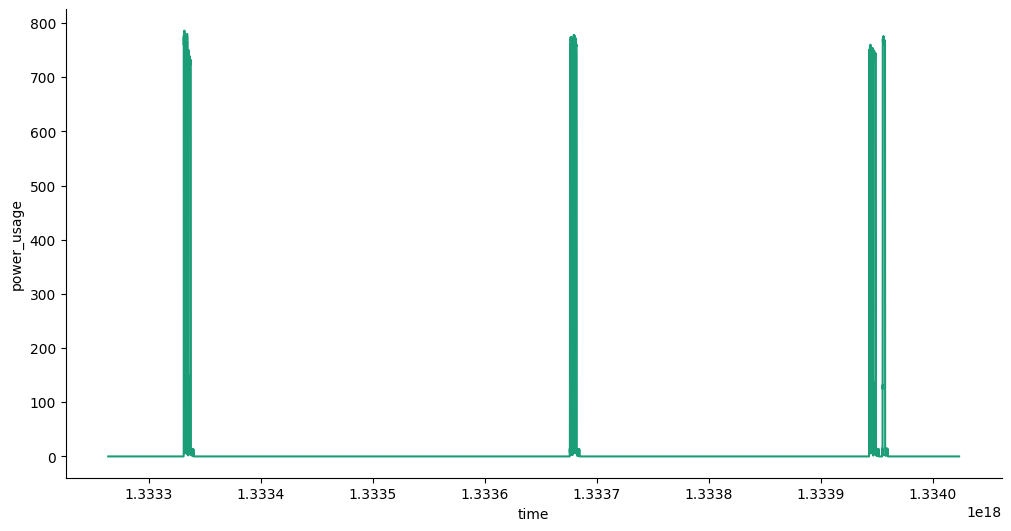

In [ ]:
# @title time vs power_usage

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['power_usage']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = fge.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('power_usage')

In [ ]:
max(fge['power_usage'])

786.0

30.0
35.0
150.0


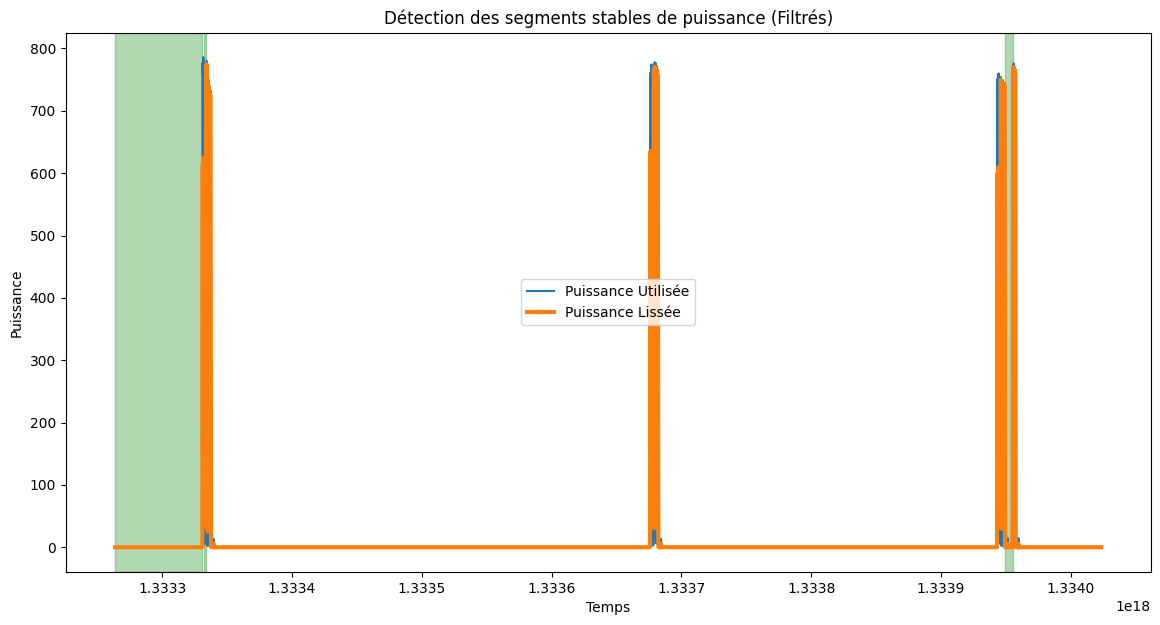

Segment stable de t=1333263720000000000 à t=1333330980000000000 avec un niveau de puissance approximatif de 0.00
Segment stable de t=1333332420000000000 à t=1333333440000000000 avec un niveau de puissance approximatif de 35.00
Segment stable de t=1333949220000000000 à t=1333955100000000000 avec un niveau de puissance approximatif de 150.00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Création d'un dataset d'exemple
np.random.seed(0)
time = np.arange(0, 300)
power_usage = np.concatenate([np.random.normal(loc, 2, 100) for loc in [50, 100, 150]])
data = fge.iloc[:] #pd.DataFrame({'time': time, 'power_usage': power_usage})

# Paramètres
window_size = 5  # Taille de la fenêtre pour la moyenne mobile
tolerance = 0.2 * max(data['power_usage'])  # Tolérance pour les fluctuations de puissance
interval = 5  # Intervalle pour arrondir les puissances
factor_k = 1.25  # Facteur k pour la comparaison des moyennes
theta = 0.2

# Calcul de la moyenne mobile
data['smoothed_power'] = data['power_usage'].rolling(window=window_size, center=True).mean()

# Arrondir les valeurs lissées à l'intervalle défini
data['smoothed_power'] = (data['smoothed_power'] // interval) * interval

# Détection des segments stables
def detect_stable_segments(data, tolerance):
    stable_segments = []
    current_segment = [data['time'].iloc[0]]
    current_level = data['smoothed_power'].iloc[0]

    for i in range(1, len(data)):
        if abs(data['smoothed_power'].iloc[i] - current_level) <= tolerance:
            current_segment.append(data['time'].iloc[i])
        else:
            if len(current_segment) > 1:
                stable_segments.append((current_segment[0], current_segment[-1], current_level))
            current_segment = [data['time'].iloc[i]]
            current_level = data['smoothed_power'].iloc[i]

    # Ajouter le dernier segment s'il est assez long
    if len(current_segment) > 1:
        stable_segments.append((current_segment[0], current_segment[-1], current_level))

    return stable_segments

stable_segments = detect_stable_segments(data, tolerance)

# Trier les segments par niveau de puissance
stable_segments.sort(key=lambda x: x[2])

# Calcul de la moyenne dynamique et comparaison avec un facteur k
def filter_segments_by_mean(segments, factor_k, theta=0.2):
    filtered_segments = [segments[0]]
    for i in range(1, len(segments)):
        segment = segments[i]
        current_mean = np.mean([seg[2] for seg in segments[:i]])
        if abs(segment[2] - current_mean) >= current_mean * factor_k:
            filtered_segments.append(segment)

    scaled_theta = theta * 100 # la plage de fluaction de puissances considérées comme identiques
    for i in range(len(filtered_segments)-2):
        print(filtered_segments [i+1][2] )
        if filtered_segments[i+1][2] - filtered_segments[i][2] <= scaled_theta:
           del filtered_segments[i]
    return filtered_segments

filtered_segments = filter_segments_by_mean(stable_segments, factor_k)

# Visualisation des segments stables filtrés
plt.figure(figsize=(14, 7))
plt.plot(data['time'], data['power_usage'], label='Puissance Utilisée')
plt.plot(data['time'], data['smoothed_power'], label='Puissance Lissée', linewidth=3)
for segment in filtered_segments:
    plt.axvspan(segment[0], segment[1], color='green', alpha=0.3)
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Puissance')
plt.title('Détection des segments stables de puissance (Filtrés)')
plt.show()

# Affichage des segments stables filtrés
for segment in filtered_segments:
    print(f'Segment stable de t={segment[0]} à t={segment[1]} avec un niveau de puissance approximatif de {segment[2]:.2f}')


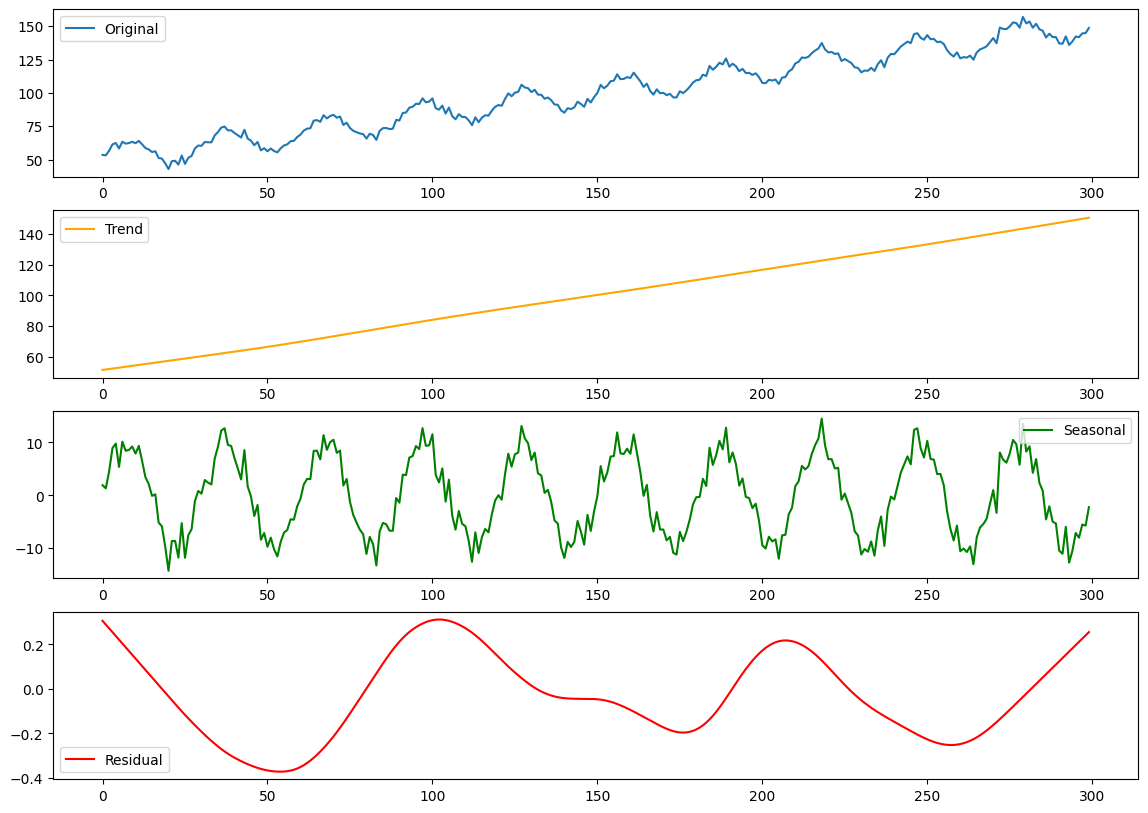

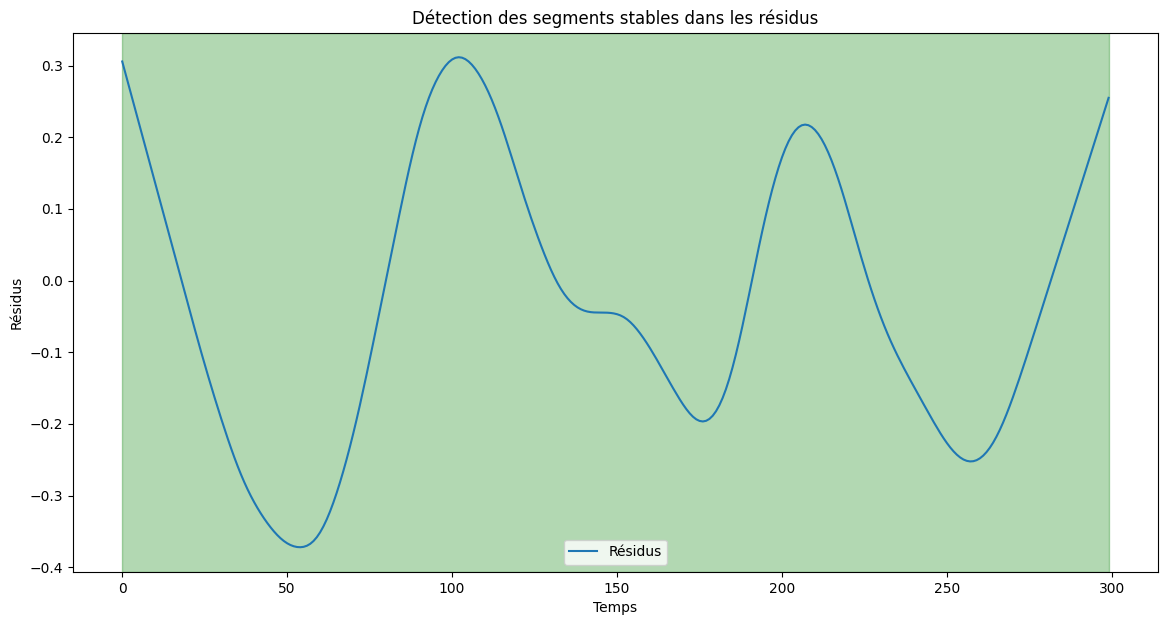

Segment stable de t=0 à t=299 avec un niveau de résidu approximatif de 0.31


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Création d'un dataset d'exemple avec saisonnalité
np.random.seed(0)
time = np.arange(0, 300)
seasonal_pattern = 10 * np.sin(2 * np.pi * time / 30)
trend = np.linspace(50, 150, 300)
noise = np.random.normal(0, 2, 300)
power_usage = seasonal_pattern + trend + noise
data = pd.DataFrame({'time': time, 'power_usage': power_usage})

# Définir explicitement la périodicité
period = 30  # Par exemple, si les données sont mensuelles avec une saisonnalité mensuelle

# Décomposition STL
stl = STL(data['power_usage'], period=period, seasonal=3)
result = stl.fit()
data['trend'] = result.trend
data['seasonal'] = result.seasonal
data['residual'] = result.resid

# Visualisation de la décomposition
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(data['time'], data['power_usage'], label='Original')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(data['time'], data['trend'], label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(data['time'], data['seasonal'], label='Seasonal', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(data['time'], data['residual'], label='Residual', color='red')
plt.legend()
plt.show()

# Détection des segments stables dans la composante résiduelle
def detect_stable_segments(data, tolerance):
    stable_segments = []
    current_segment = [data.index[0]]
    current_level = data.iloc[0]

    for i in range(1, len(data)):
        if abs(data.iloc[i] - current_level) <= tolerance:
            current_segment.append(data.index[i])
        else:
            if len(current_segment) > 1:
                stable_segments.append((current_segment[0], current_segment[-1], current_level))
            current_segment = [data.index[i]]
            current_level = data.iloc[i]

    # Ajouter le dernier segment s'il est assez long
    if len(current_segment) > 1:
        stable_segments.append((current_segment[0], current_segment[-1], current_level))

    return stable_segments

tolerance = 5  # Tolérance pour les fluctuations résiduelles
stable_segments = detect_stable_segments(data['residual'], tolerance)

# Visualisation des segments stables sur les résidus
plt.figure(figsize=(14, 7))
plt.plot(data['time'], data['residual'], label='Résidus')
for segment in stable_segments:
    plt.axvspan(segment[0], segment[1], color='green', alpha=0.3)
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Résidus')
plt.title('Détection des segments stables dans les résidus')
plt.show()

# Affichage des segments stables
for segment in stable_segments:
    print(f'Segment stable de t={segment[0]} à t={segment[1]} avec un niveau de résidu approximatif de {segment[2]:.2f}')
